In [1]:
import os
import numpy as np
import time
import copy
import sys

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import molog_loading_utils as mlu

In [2]:
#folder = "/home/kristjan/sshfs/daint_scratch/cp2k_cnt_orbitals/"
#
#file_basis_set = folder + "BR"
#
#
#file_xyz = folder + "c2h2_rot/p.xyz"
#
#file_molog = folder + "c2h2_rot/morb_not_all/PROJ-COEFF-1_0.MOLog"
#
#file_cp2k_inp = folder + "c2h2_rot/morb_not_all/cp2k.inp"


#folder = "/home/kristjan/local_work/12mol_7agnr/"
#
#file_basis_set = folder + "BR"
#
#
#file_xyz = folder + "12mol_7agnr_opt.xyz"
#
#file_molog = folder + "morbs/PROJ-COEFF-1_0.MOLog"
#
#file_cp2k_inp = folder + "morbs/cp2k.inp"


#folder = "/home/kristjan/local_work/finite_defect_cnt_morbs/"
#
#file_basis_set = folder + "BR"
#
#
#file_xyz = folder + "finite_defect_cnt.xyz"
#
#file_molog = folder + "PROJ-COEFF-1_0.MOLog"
#
#file_cp2k_inp = folder + "cp2k.inp"


#folder = "/home/kristjan/local_work/finite_ideal_cnt_morbs/"
#
#file_basis_set = folder + "BR"
#
#file_xyz = folder + "finite_ideal_cnt.xyz"
#
#file_molog = folder + "PROJ-COEFF-1_0.MOLog"
#
#file_cp2k_inp = folder + "cp2k.inp"


folder = "/home/kristjan/local_work/cnt-capped-ideal-morbs/"

file_basis_set = folder + "BR"

file_xyz = folder + "ideal_cnt_capped.xyz"

file_molog = folder + "molog_cropped"

file_cp2k_inp = folder + "cp2k.inp"


#folder = "/home/kristjan/local_work/cnt-capped-h-AB-morbs/"
#
#file_basis_set = folder + "BR"
#
#file_xyz = folder + "capped-cnt-h-AB.xyz"
#
#file_molog = folder + "molog_cropped"
#
#file_cp2k_inp = folder + "cp2k.inp"

In [3]:
time1 = time.time()
elem_basis_names, cell, cell_n = mlu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time2 = time.time()
at_positions, at_elems = mlu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time2))

time3 = time.time()
basis_sets = mlu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time3))

time4 = time.time()
morb_composition, morb_energies = mlu.read_and_process_molog(file_molog)
print("Read molog: %.3f" % (time.time()-time4))

Read cp2k input: 0.015
Read xyz: 0.094
Read basis sets: 0.005
Reading CP2K MOs from:/home/kristjan/local_work/cnt-capped-ideal-morbs/molog_cropped
Metallic system
Found 1001 MOs spanned by 40320 basis functions centered on 2880 atoms.
Read molog: 150.413


In [4]:
def spherical_harmonic_grid(l, m, x_grid, y_grid, z_grid):
    c = (2.0/np.pi)**(3.0/4.0)
    
    # s orbitals
    if (l, m) == (0, 0):
        return c
    
    # p orbitals
    elif (l, m) == (1, -1):
        return c*2.0*y_grid
    elif (l, m) == (1, 0):
        return c*2.0*z_grid
    elif (l, m) == (1, 1):
        return c*2.0*x_grid
    
    # d orbitals
    elif (l, m) == (2, -2):
        return c*4.0*x_grid*y_grid
    elif (l, m) == (2, -1):
        return c*4.0*y_grid*z_grid
    elif (l, m) == (2, 0):
        return c*2.0/np.sqrt(3)*(2*z_grid**2-x_grid**2-y_grid**2)
    elif (l, m) == (2, 1):
        return c*4.0*z_grid*x_grid
    elif (l, m) == (2, 2):
        return c*2.0*(x_grid**2-y_grid**2)
    
    print("No spherical harmonic found for l=%d, m=%d" % (l, m))
    return 0

                
def add_local_to_global_grid(loc_grid, glob_grid, origin_diff):
    loc_nx, loc_ny = np.shape(loc_grid)
    glob_nx, glob_ny = np.shape(glob_grid)
    od = origin_diff
    
    # Move the origin_diff vector to the main global cell (not an image)
    od = od % glob_nx
        
    ixs = [[od[0], od[0] + loc_nx]]
    l_ixs = [0]
    while ixs[-1][1] > glob_nx:
        overshoot = ixs[-1][1]-glob_nx
        ixs[-1][1] = glob_nx
        l_ixs.append(l_ixs[-1]+glob_nx-ixs[-1][0])
        ixs.append([0, overshoot])
    l_ixs.append(loc_nx)
        
    iys = [[od[1], od[1] + loc_ny]]
    l_iys = [0]
    while iys[-1][1] > glob_ny:
        overshoot = iys[-1][1]-glob_ny
        iys[-1][1] = glob_ny
        l_iys.append(l_iys[-1]+glob_ny-iys[-1][0])
        iys.append([0, overshoot])
    l_iys.append(loc_ny)
        
    for i, ix in enumerate(ixs):
        for j, iy in enumerate(iys):
            glob_grid[ix[0]:ix[1], iy[0]:iy[1]] += loc_grid[l_ixs[i]:l_ixs[i+1], l_iys[j]:l_iys[j+1]]
        
        
#loc_grid = np.ones((17, 17))
#glob_grid = np.zeros((8, 8))
#origin_diff = np.array([2, 2])
#
#add_local_to_global_grid(loc_grid, glob_grid, origin_diff)
#glob_grid             

In [5]:
height = 0.5 # Plane distance in z direction from topmost atom; angstroms

emax =  2.0 # eV
emin = -2.0 # eV

In [6]:
# Sort out molecular orbitals in the specified energy range
sel_morb_composition = []
sel_morb_energies = []
for i_mo, morb in enumerate(morb_composition):
    energy = morb_energies[i_mo]
    if energy > emin and energy < emax:
        sel_morb_energies.append(energy)
        sel_morb_composition.append(morb)
        
print("Selected mol. orbitals %d/%d" % (len(sel_morb_composition), len(morb_composition)))

Selected mol. orbitals 717/1001


In [7]:
# Define the plane

time1 = time.time()

carb_positions = at_positions[np.array(at_elems)[:, 0] == 'C']

plane_z = np.max(carb_positions[:, 2]) + height*ang_2_bohr

# Use similar grid spacing to cp2k cube files
dv = cell[0:2]/cell_n[0:2]
x_arr = np.arange(0, cell[0], dv[0])
y_arr = np.arange(0, cell[1], dv[1])
x_grid, y_grid = np.meshgrid(x_arr, y_arr, indexing='ij')

# Define small grid for orbital evaluation
# and convenient PBC implementation
loc_cell = np.array([10.0,  10.0])*ang_2_bohr
x_arr_loc = np.arange(0, loc_cell[0], dv[0])
y_arr_loc = np.arange(0, loc_cell[1], dv[1])
loc_cell_n = np.array([len(x_arr_loc), len(y_arr_loc)])
# Define it such that the origin is somewhere
# in the middle but exactly on a grid point
mid_ixs = (loc_cell_n/2).astype(int)
x_arr_loc -= x_arr_loc[mid_ixs[0]]
y_arr_loc -= y_arr_loc[mid_ixs[1]]
x_grid_loc, y_grid_loc = np.meshgrid(x_arr_loc, y_arr_loc, indexing='ij')

# Some info
print("Main cell:   ", cell, cell_n)
print("Local plane: ", loc_cell, loc_cell_n)


morb_planes = [np.zeros(cell_n[0:2]) for _ in range(len(sel_morb_composition))]

print("---- Setup: %.4f" % (time.time() - time1))

time_radial_calc = 0.0
time_spherical = 0.0
time_loc_glob_add = 0.0


for i_at in range(len(at_positions)):
        elem = at_elems[i_at][0]
        pos = at_positions[i_at]
        
        # how does the position match with the grid?
        int_shift = (pos[0:2]/dv).astype(int)
        frac_shift = pos[0:2]/dv - int_shift
        
        # Shift the local grid such that origin is on the atom
        x_grid_rel_loc = x_grid_loc - frac_shift[0]*dv[0]
        y_grid_rel_loc = y_grid_loc - frac_shift[1]*dv[1]
        
        z_rel = plane_z - pos[2]
        
        r_vec_2 = x_grid_rel_loc**2 + y_grid_rel_loc**2 + z_rel**2
        
        for i_shell, shell in enumerate(basis_sets[elem]):
            l = shell[0]
            es = shell[1]
            cs = shell[2]
            
            # Calculate the radial part of the atomic orbital
            time2 = time.time()
            radial_part = np.zeros(loc_cell_n)
            for e, c in zip(es, cs):
                radial_part += c*np.exp(-1.0*e*r_vec_2)
            time_radial_calc += time.time() - time2
            
            for i, m in enumerate(range(-l, l+1, 1)):
                time2 = time.time()
                atomic_orb = radial_part*spherical_harmonic_grid(l, m,
                                                                 x_grid_rel_loc,
                                                                 y_grid_rel_loc,
                                                                 z_rel)
                time_spherical += time.time() - time2
                
                for i_mo in range(len(sel_morb_composition)):
                    coef = sel_morb_composition[i_mo][i_at][i_shell][i]

                    # Add the atomic orbital on the local grid to the global grid
                    origin_diff = int_shift - mid_ixs
                    time2 = time.time()
                    add_local_to_global_grid(coef*atomic_orb, morb_planes[i_mo], origin_diff)
                    time_loc_glob_add += time.time() - time2
            

print("---- Radial calc time : %4f" % time_radial_calc)
print("---- Spherical calc time : %4f" % time_spherical)
print("---- Loc -> glob time : %4f" % time_loc_glob_add)
print("---- Total time: %.4f"%(time.time() - time1))                 

Main cell:    [ 1001.55484649    47.24315314    47.24315314] [6625  313  313]
Local plane:  [ 18.89726125  18.89726125] [126 126]
---- Setup: 0.0954
---- Radial calc time : 24.810750
---- Spherical calc time : 1.850742
---- Loc -> glob time : 2200.747189
---- Total time: 2315.4982


In [8]:
i_homo = 0
i_lumo = 0

for i, en in enumerate(sel_morb_energies):
    if en > 0.0:
        i_lumo = i
        i_homo = i - 1
        break
print(i_homo, i_lumo)

423 424


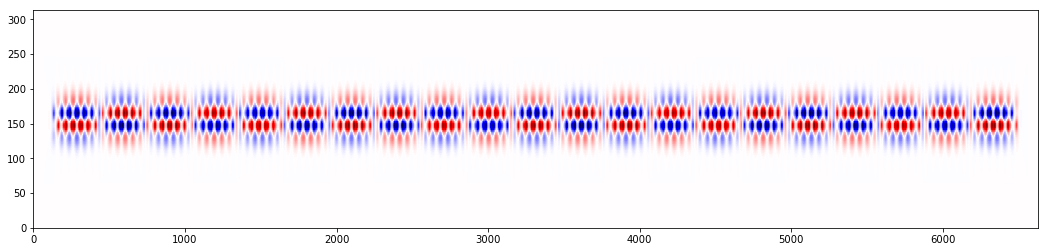

In [9]:
plt.figure(figsize=(18, 4))
plot_data = morb_planes[i_homo-11].T
max_abs = np.max(np.abs(plot_data))
plt.pcolormesh(plot_data, cmap='seismic', vmax=max_abs, vmin=-max_abs)
#plt.colorbar()
plt.show()

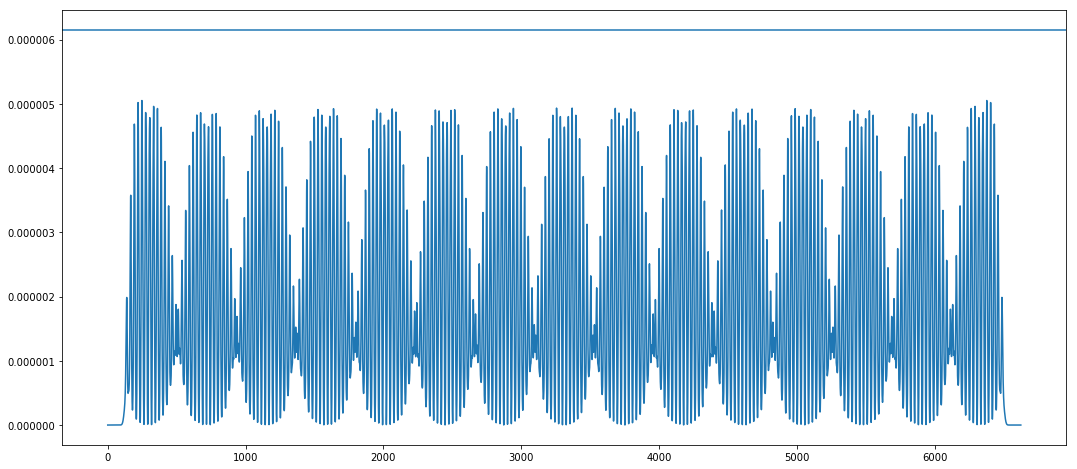

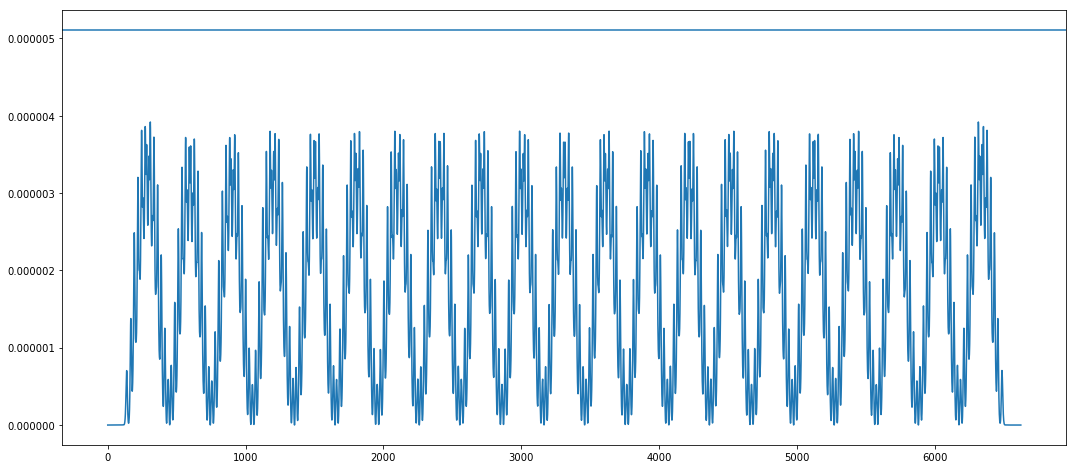

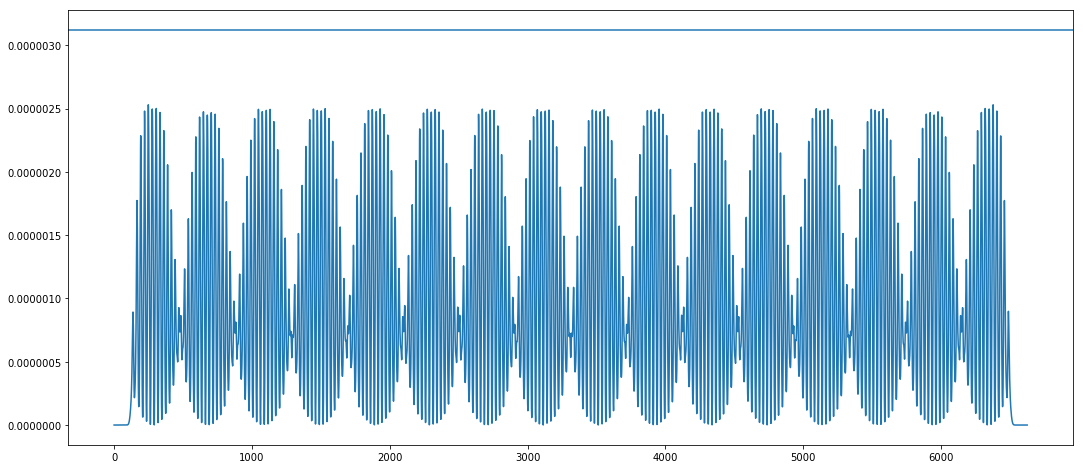

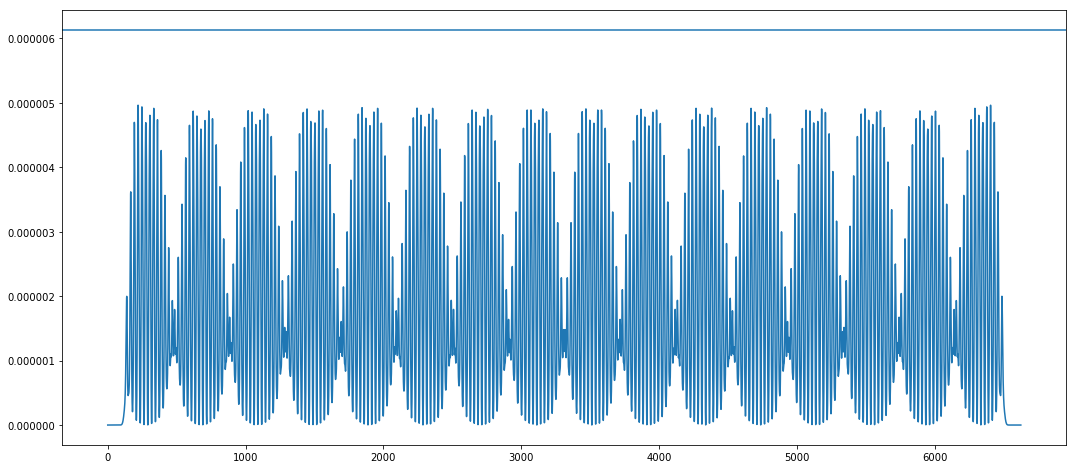

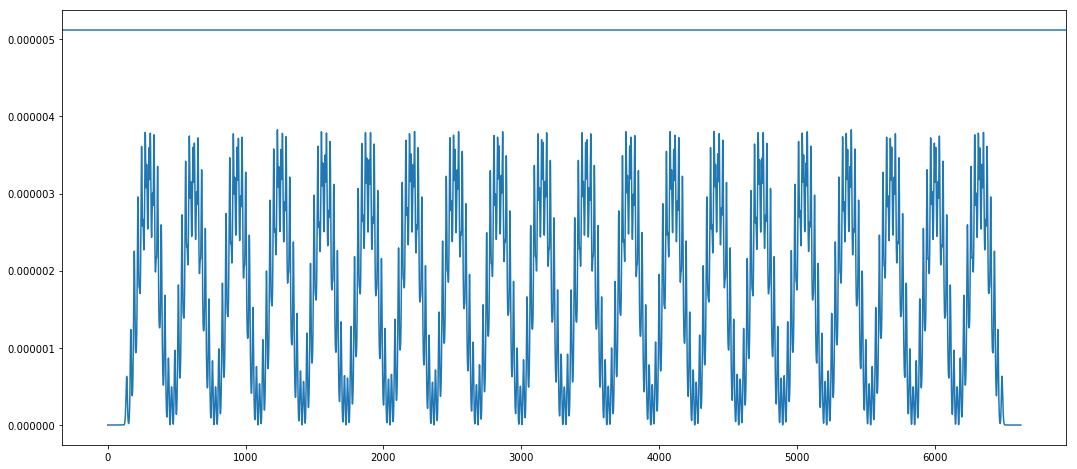

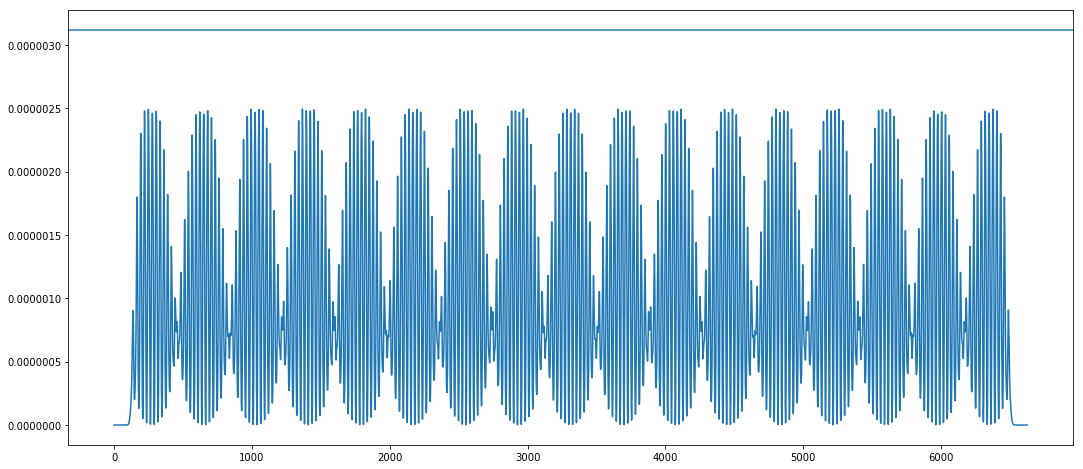

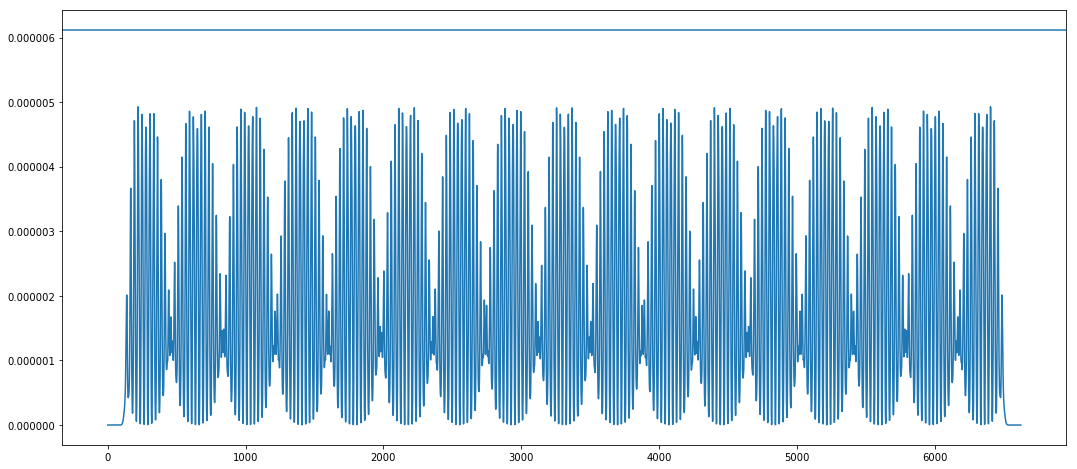

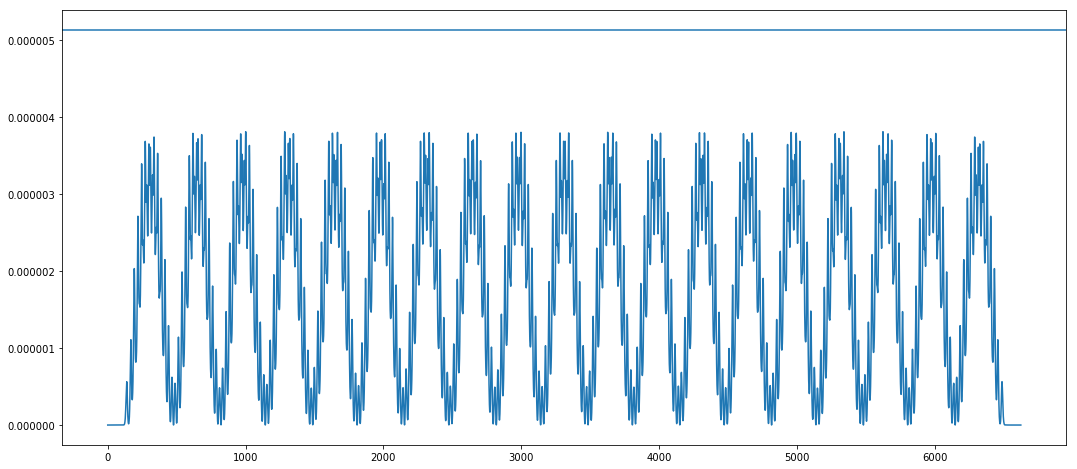

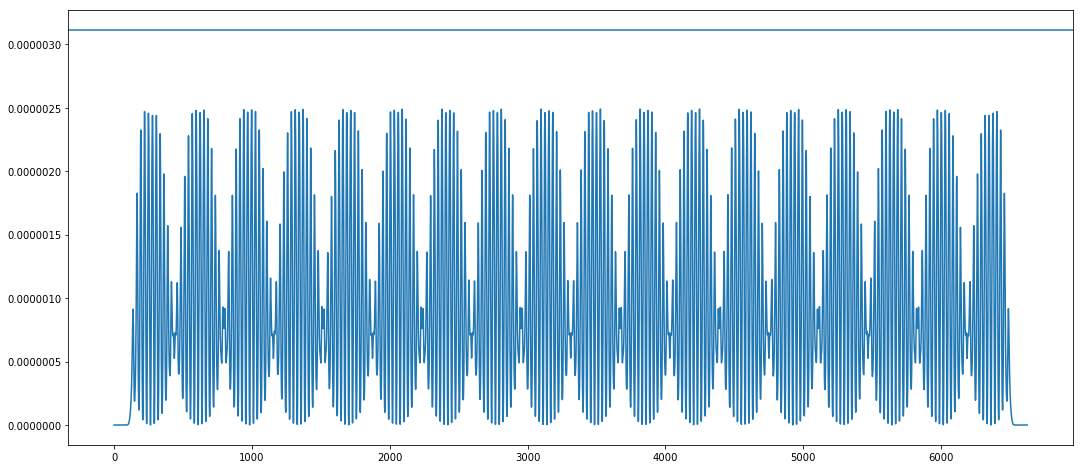

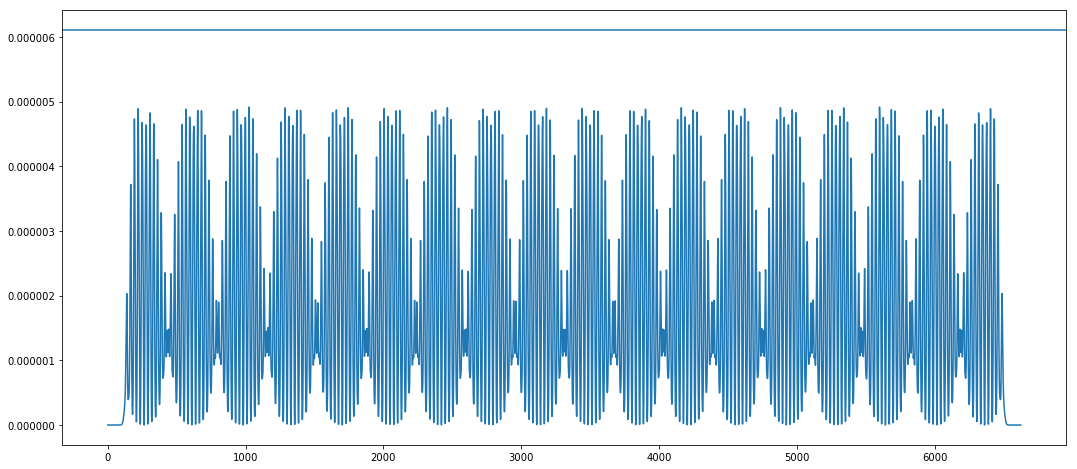

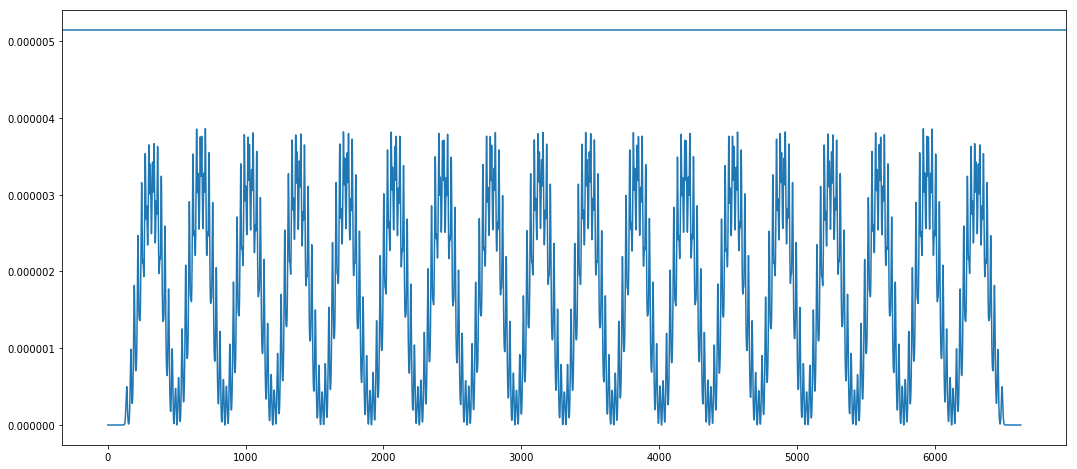

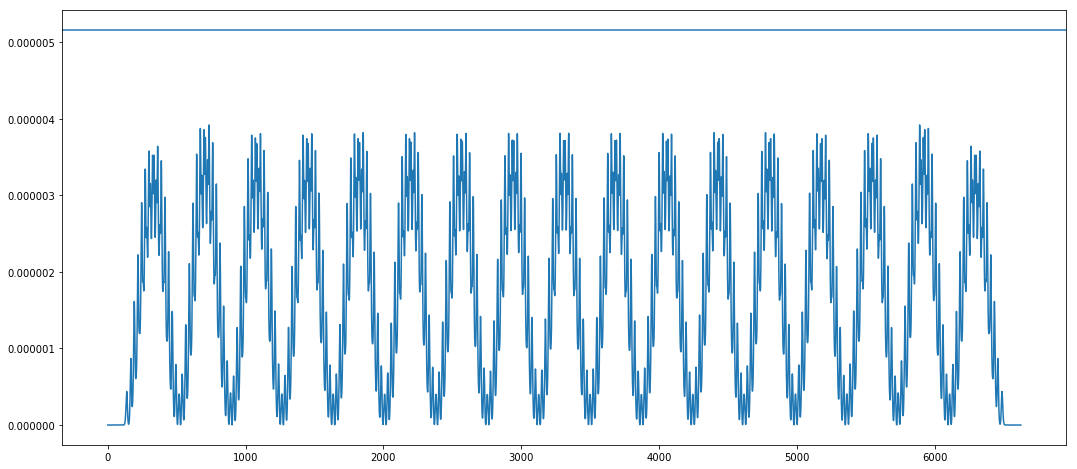

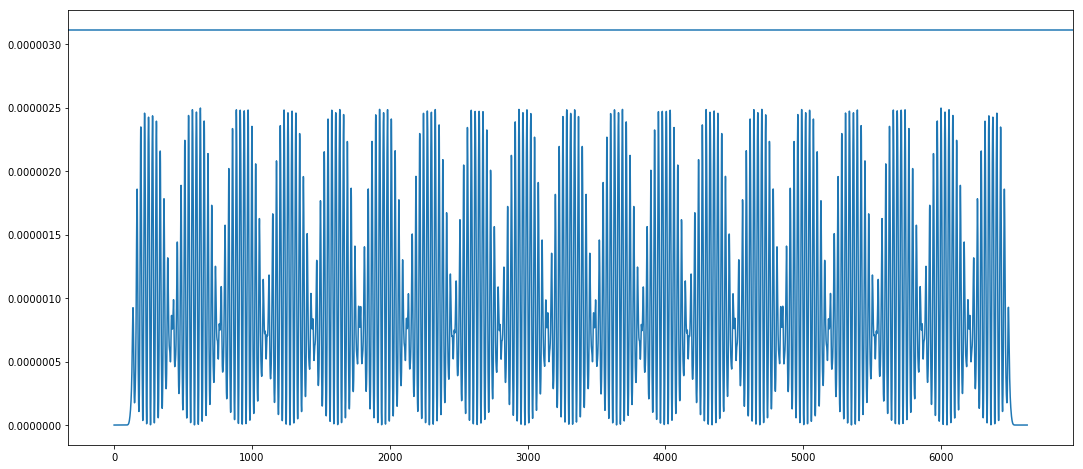

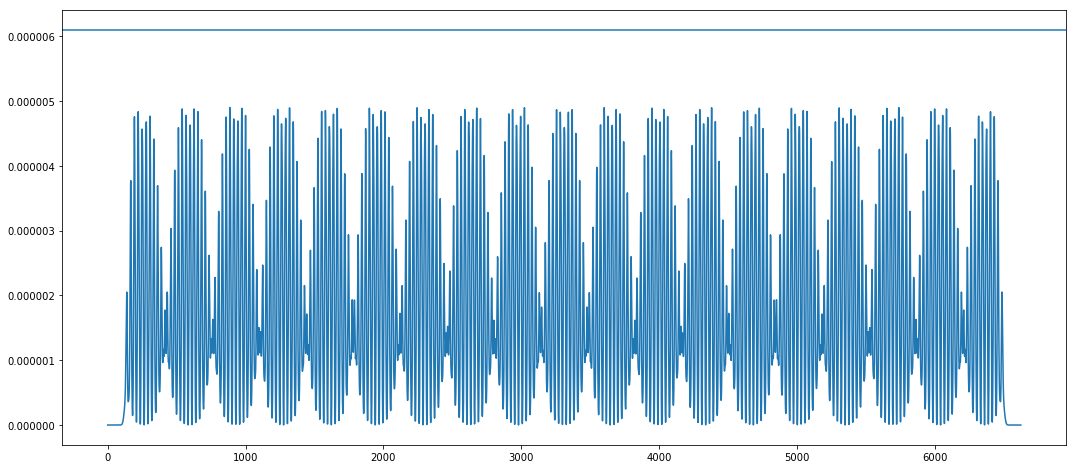

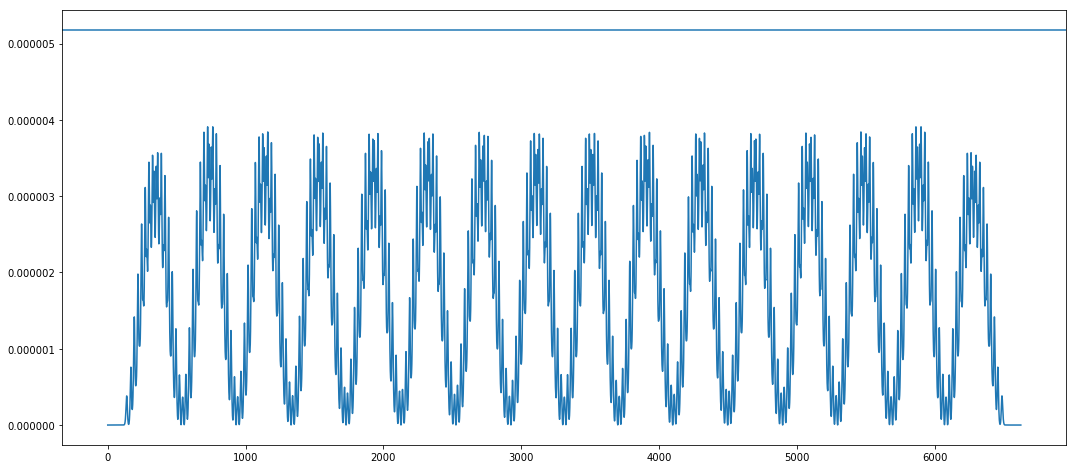

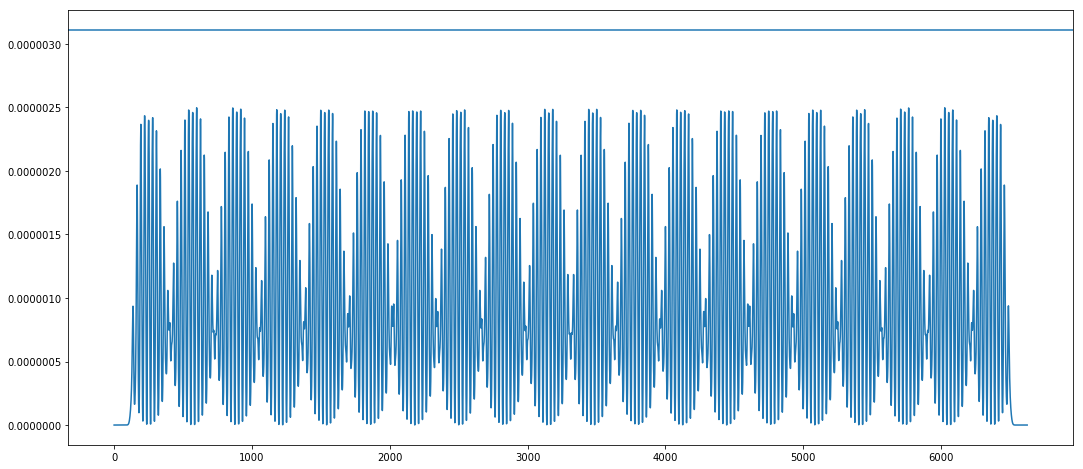

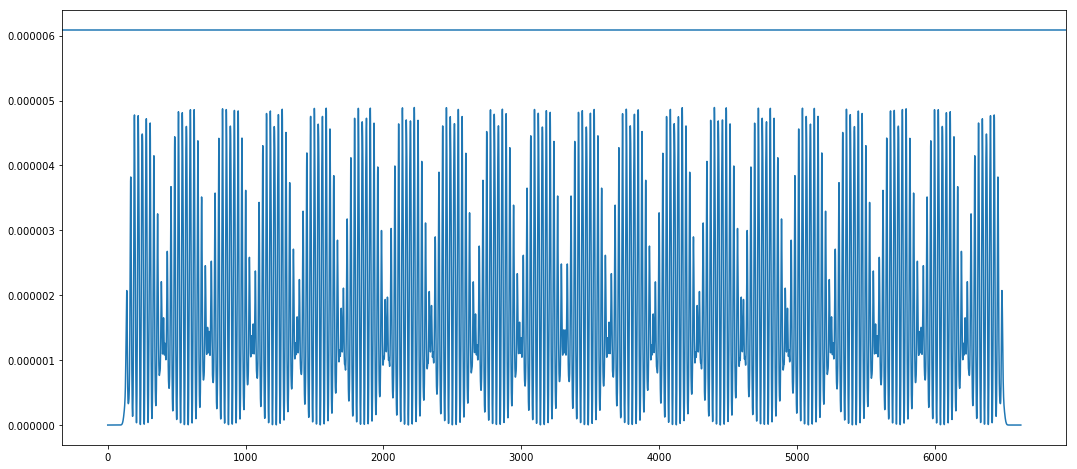

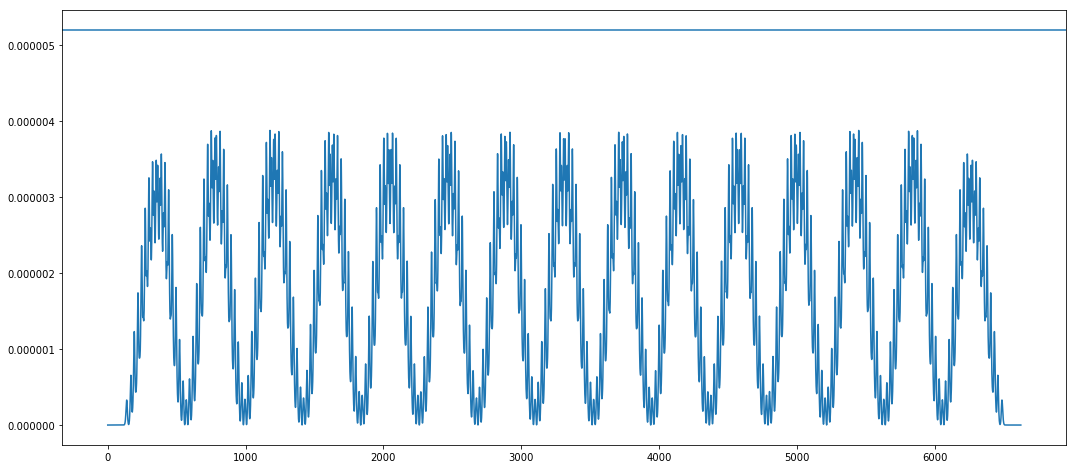

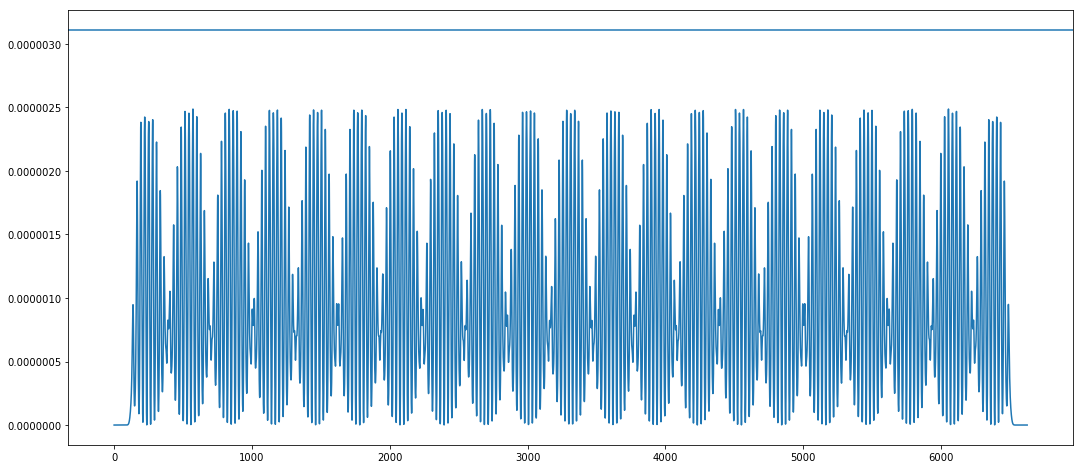

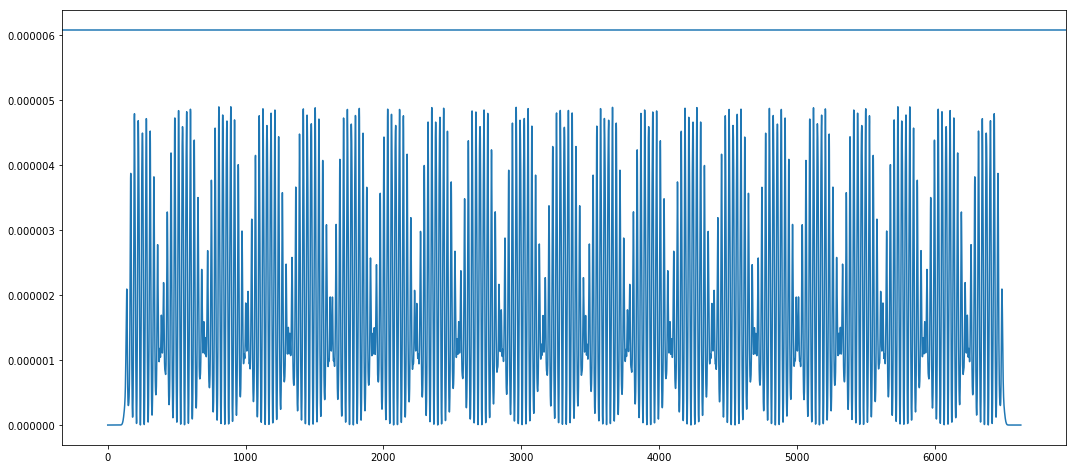

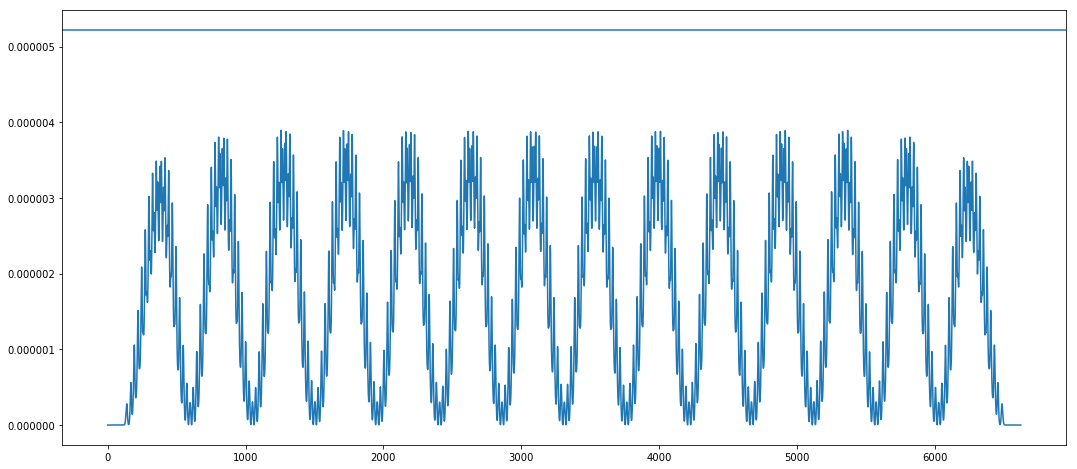

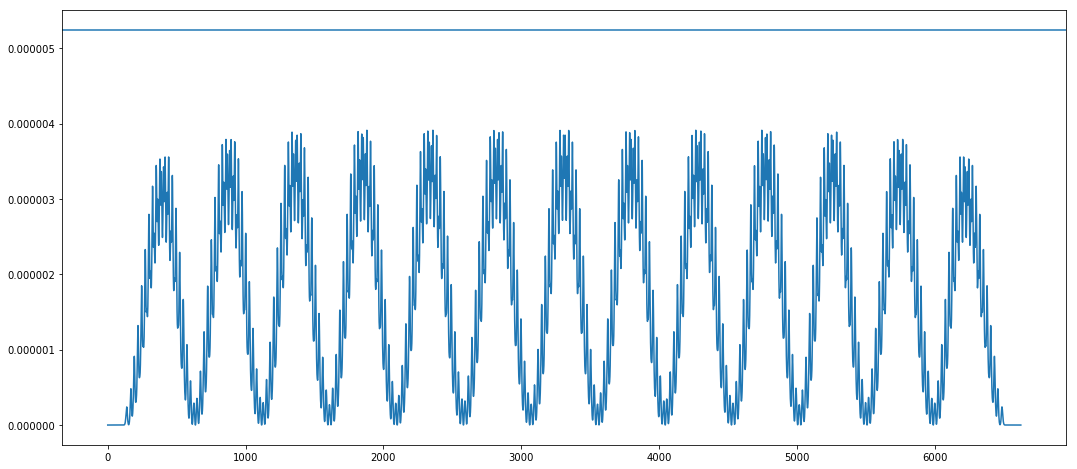

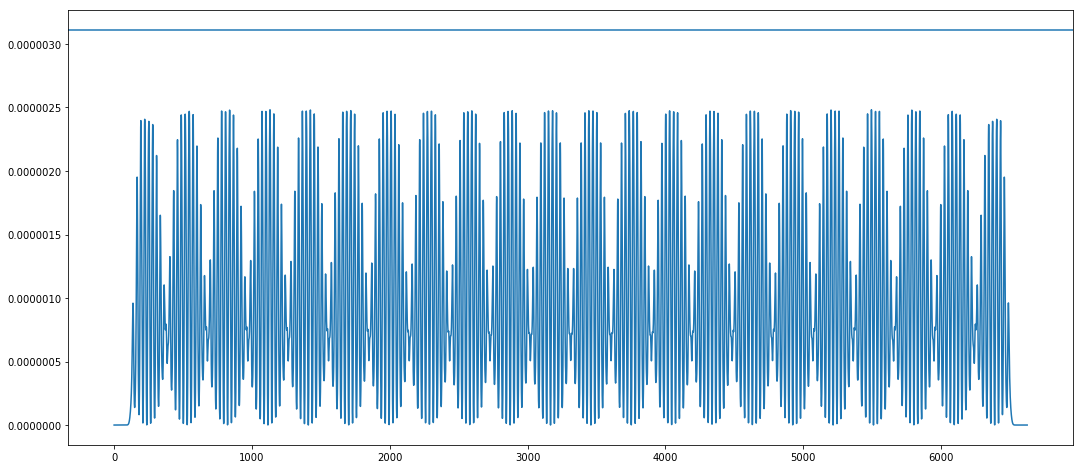

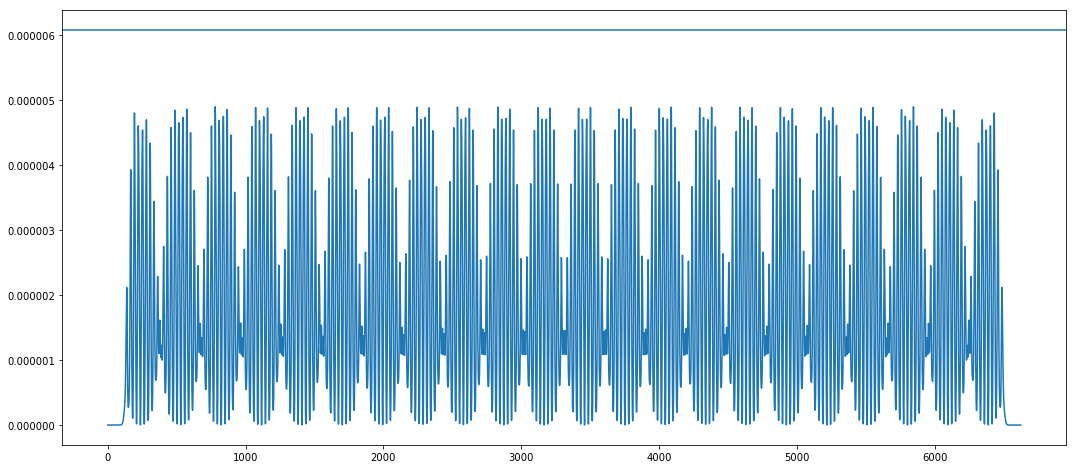

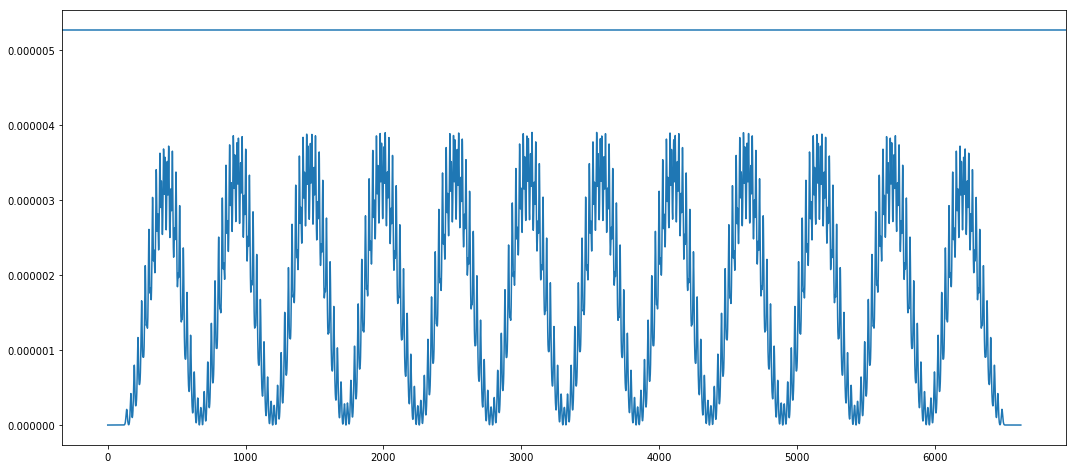

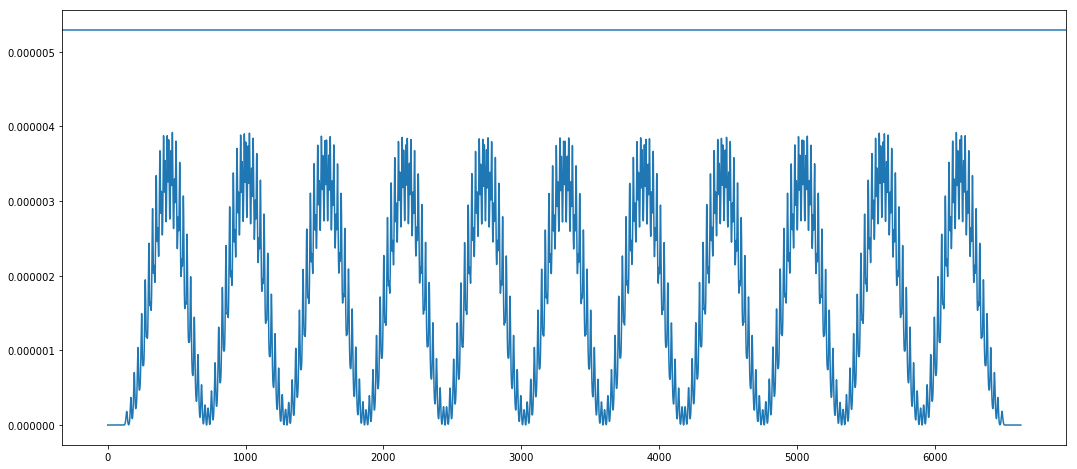

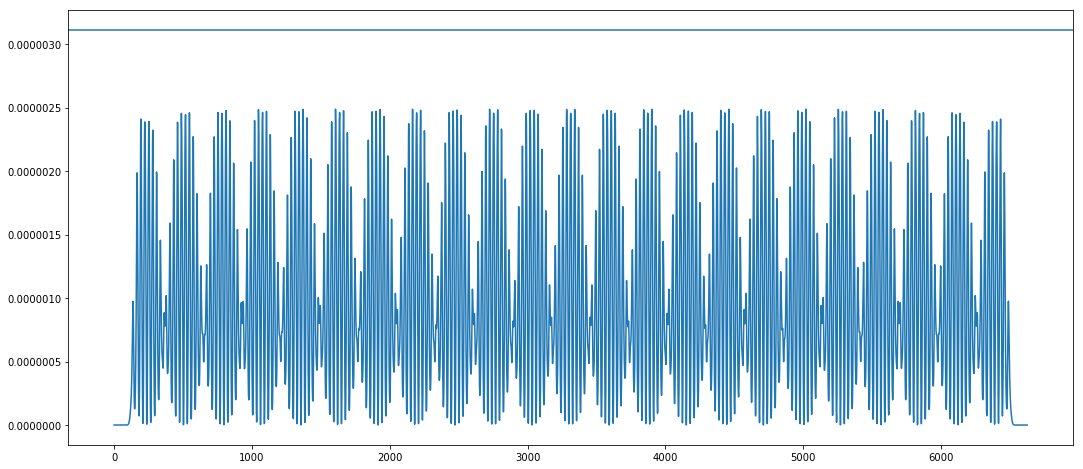

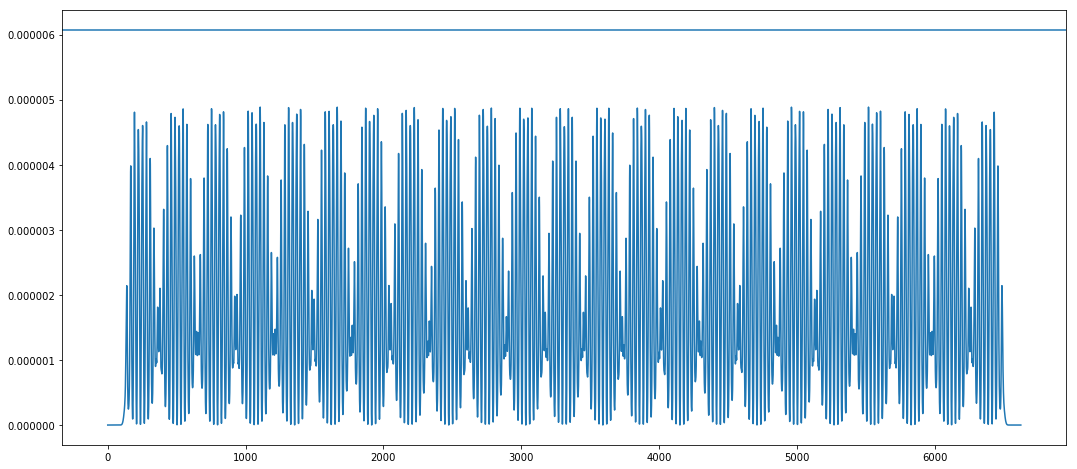

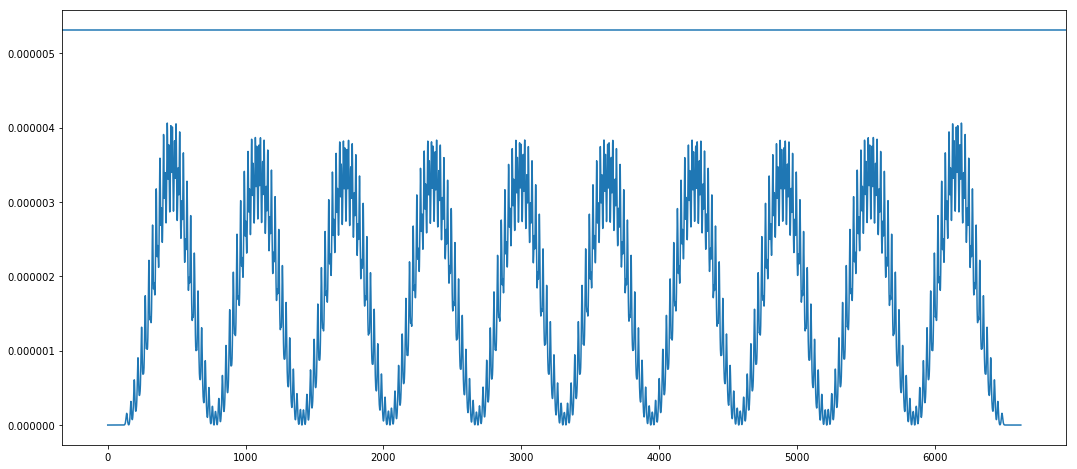

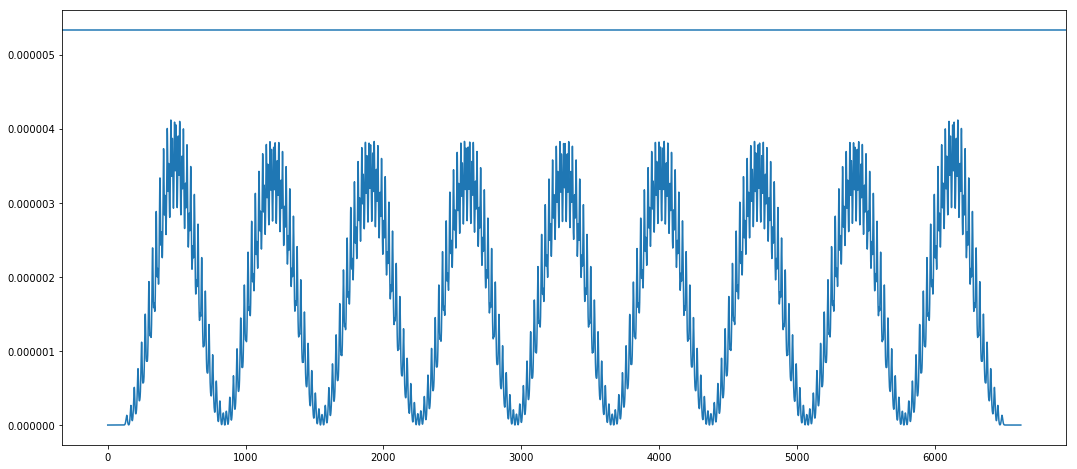

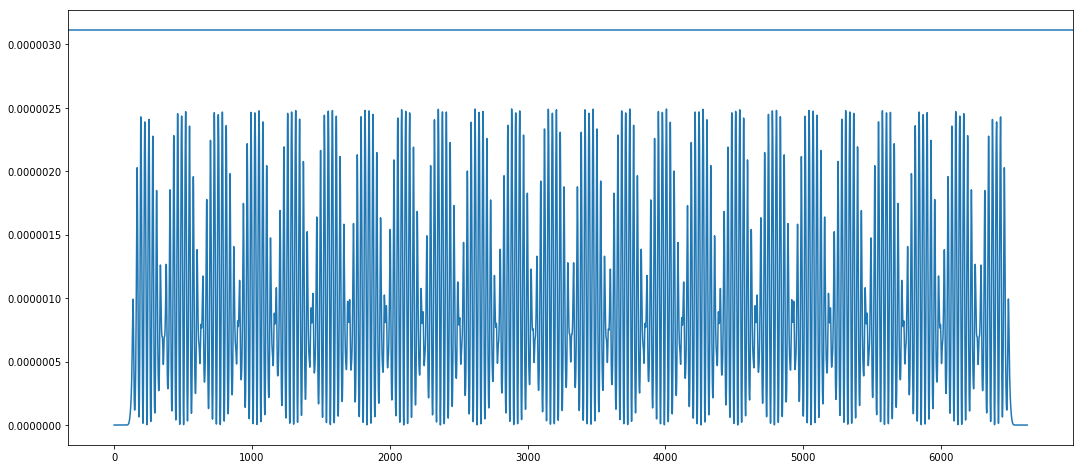

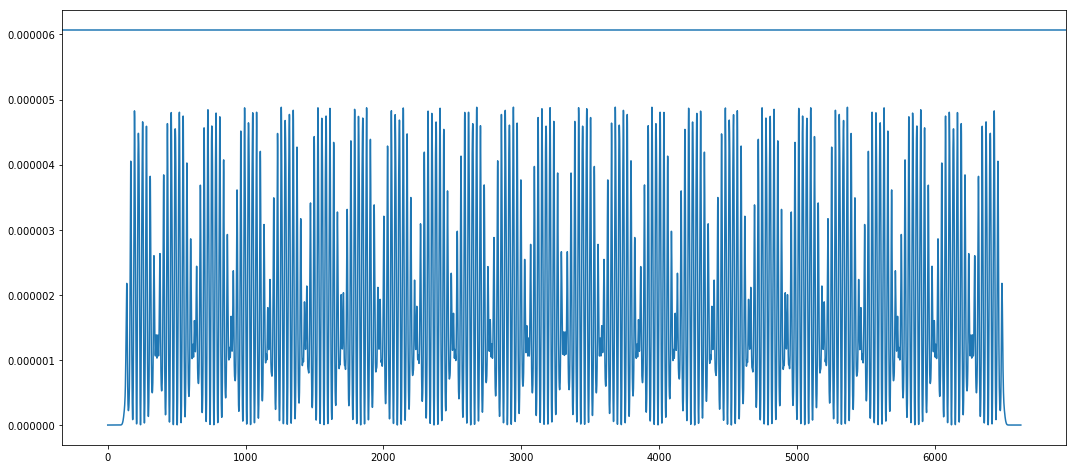

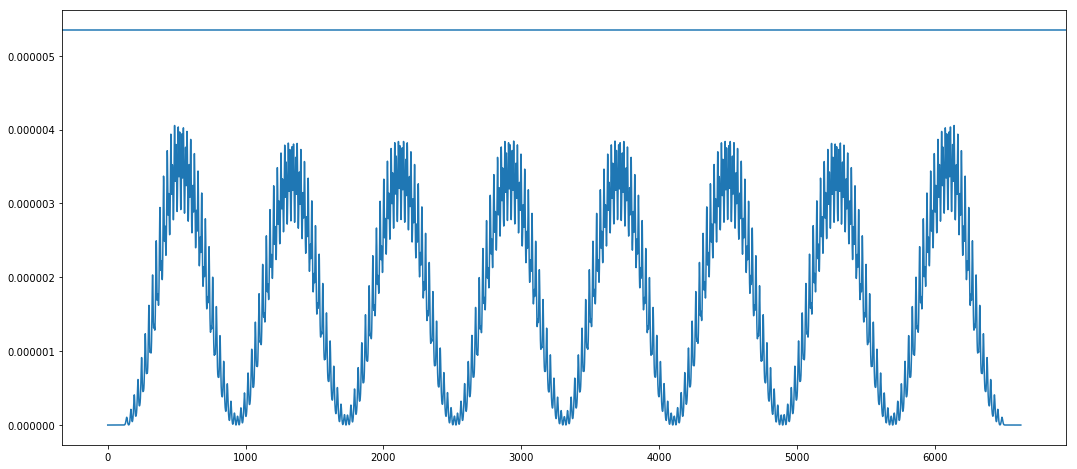

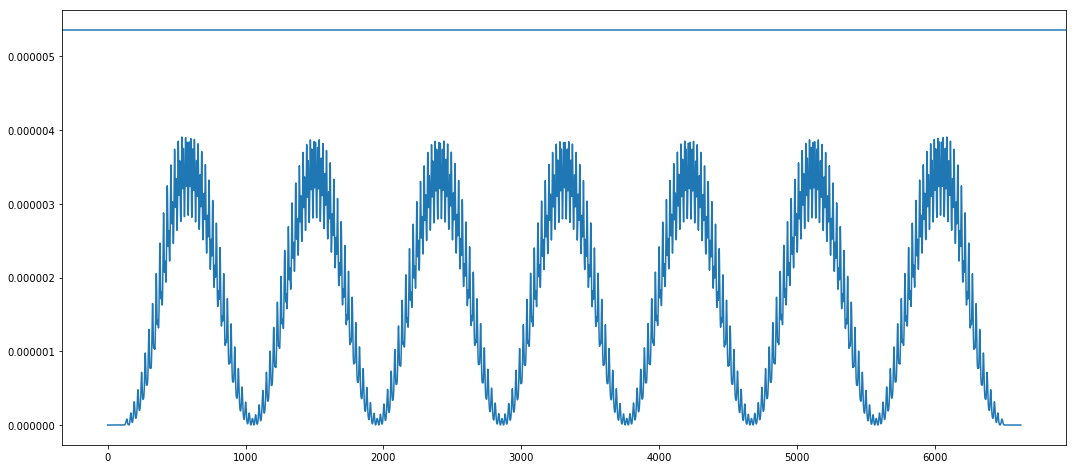

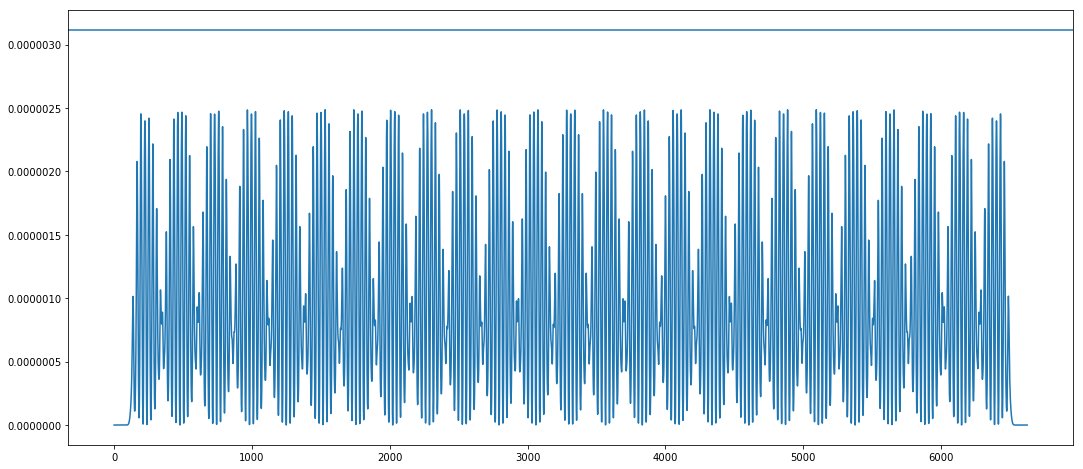

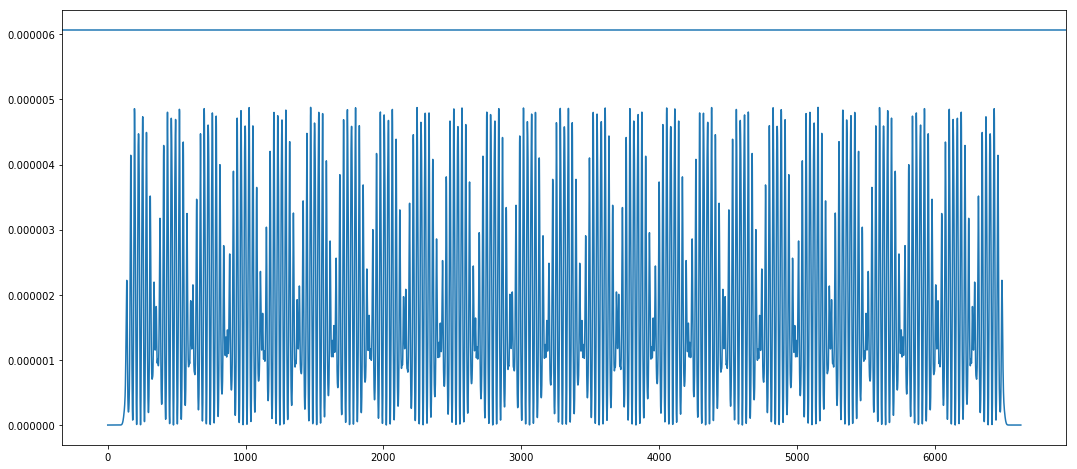

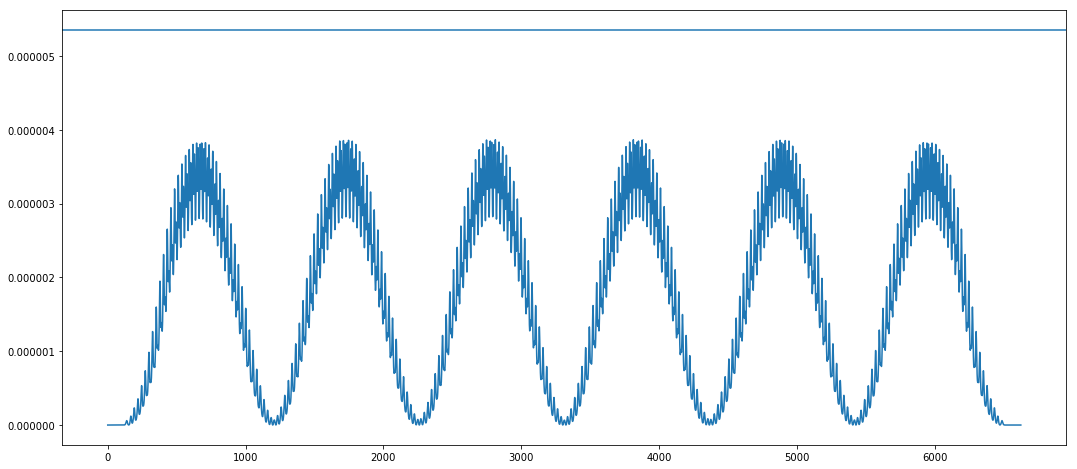

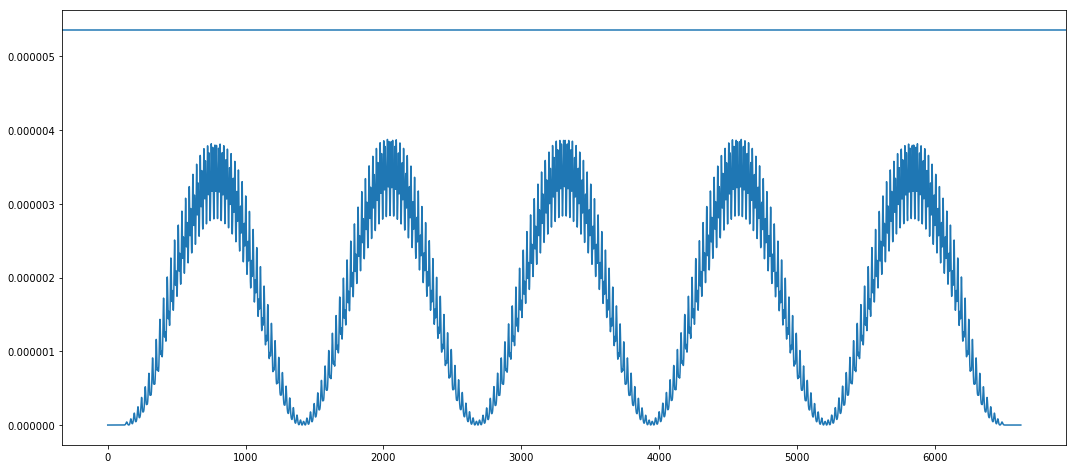

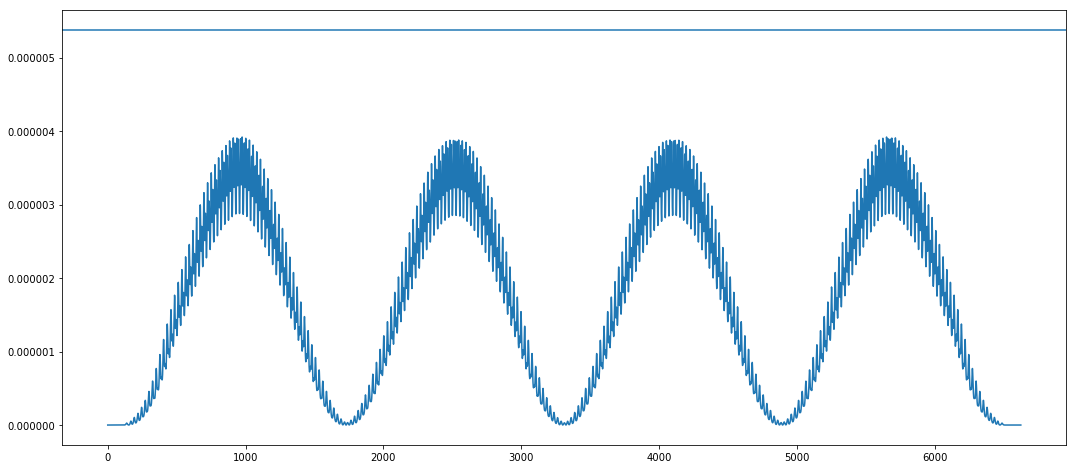

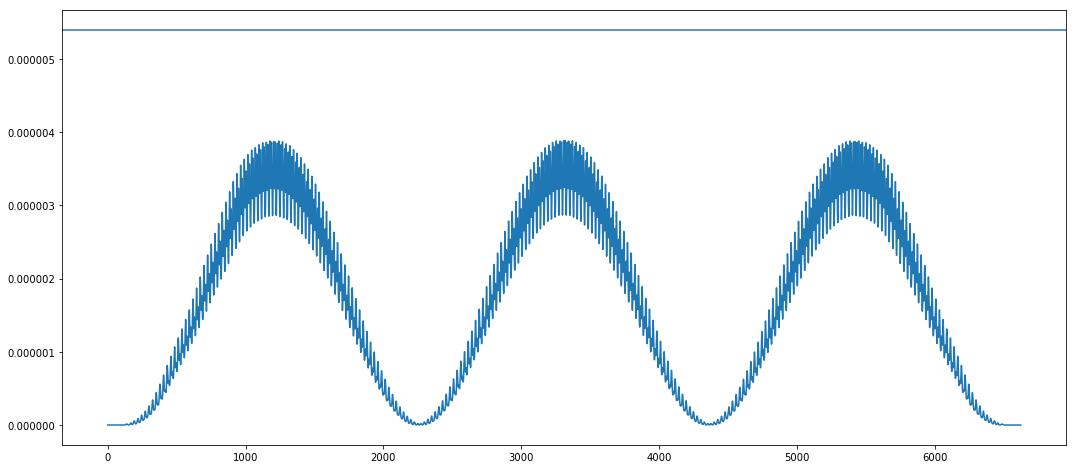

In [10]:
for i in range(10, 50):
    plt.figure(figsize=(18, 8))
    plot_data = np.mean(morb_planes[i_homo-i]**2, axis=1).T
    plt.plot(plot_data)
    plt.axhline(np.mean(plot_data)+3*np.std(plot_data))
    #plt.colorbar()
    plt.show()

In [15]:
print(sel_morb_energies[i_homo+3])
print(sel_morb_energies[i_homo+2])
print(sel_morb_energies[i_homo+1])
print(sel_morb_energies[i_homo])
print(sel_morb_energies[i_homo-1])
print(sel_morb_energies[i_homo-2])

0.0359790877823
0.0167245550591
0.0150456329474
-0.0028765096667
-0.00287715441044
-0.0138322805066


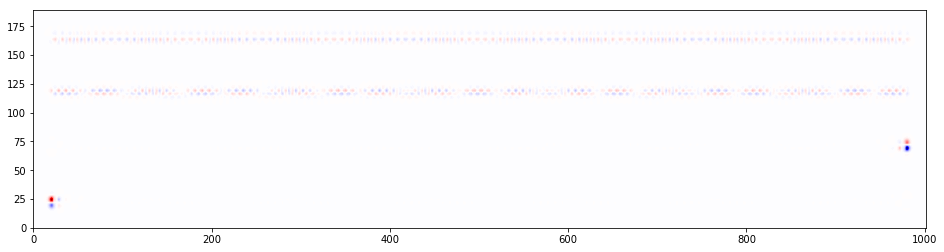

In [16]:
select = [i_homo - 1, i_homo, i_lumo, i_lumo + 1]

sel_morbs = np.zeros((cell_n[0], 4*cell_n[1]))

for i, i_mo in enumerate(select):
    sel_morbs[:, i*cell_n[1]:(i+1)*cell_n[1]] = morb_planes[i_mo]
    
y_arr_inc = np.arange(0, 4*cell[1], dv[1])

x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')
    
plt.figure(figsize=(16, 4))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, cmap='seismic') # seismic bwr
#plt.axvline(np.max(x_grid_inc)/2)
plt.show()

In [41]:
de = 0.01

# broadening
fwhm = 0.15

def lorentzian(x):
    gamma = 0.5*fwhm
    return gamma/(np.pi*(x**2+gamma**2))
                     
def gaussian(x):
    sigma = fwhm/2.3548
    return np.exp(-x**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))


e_arr = np.arange(emin, emax+de, de)

x_arr_ang = x_arr / ang_2_bohr

x_e_grid, e_grid = np.meshgrid(x_arr_ang, e_arr, indexing='ij')

pldos = np.zeros((cell_n[0], len(e_arr)))
pldos_sr = np.zeros((cell_n[0], len(e_arr)))

for i_mo, morb_plane in enumerate(morb_planes):
    en = sel_morb_energies[i_mo]
    avg_morb = np.mean(morb_plane**2, axis=1)
    
    avg_morb_surpressed = np.copy(avg_morb)
    surp_val = np.mean(avg_morb) + 3*np.std(avg_morb)
    avg_morb_surpressed[avg_morb > surp_val] = surp_val
    
    morb_ldos_broad = np.outer(avg_morb, lorentzian(e_arr - en))
    
    morb_ldos_broad_sr = np.outer(avg_morb_surpressed, lorentzian(e_arr - en))
    
    pldos += morb_ldos_broad
    
    pldos_sr += morb_ldos_broad_sr


dx = x_arr_ang[1] - x_arr_ang[0] # angstroms !!!


In [42]:
xzero_l = 230.0
xzero_r = 230.0

nzero_l = int(np.round(xzero_l/dx))
nzero_r = int(np.round(xzero_r/dx))

pldos[:nzero_l] = 0.0
pldos[-nzero_r:] = 0.0

In [43]:
# Crop from the ends!
lattice_param = 3 * 1.42

xcrop = 10.0
# align cropping, such that remaining area is a multiple of lattice param
xcrop = (np.max(x_arr_ang)-(np.max(x_arr_ang)-2*xcrop)//lattice_param*lattice_param)/2

surp = False

ncrop_l = int(np.round(xcrop/dx))
ncrop_r = int(np.round(xcrop/dx))

pldos_cropped = np.copy(pldos[ncrop_l:-ncrop_r])
x_e_grid_cropped = x_e_grid[ncrop_l:-ncrop_r]
e_grid_cropped = e_grid[ncrop_l:-ncrop_r]

max_val = np.max(pldos_cropped)

# Surpress regions:
#xsurp = [(220, 230), (300, 310)]
#for sr in xsurp:
#    surp = True
#    nsurp_l = int(np.round((sr[0]-xcrop)/dx))
#    nsurp_r = int(np.round((sr[1]-xcrop)/dx))
#    (pldos_cropped[nsurp_l:nsurp_r])[pldos_cropped[nsurp_l:nsurp_r] > 0.1*max_val] = 0.1*max_val

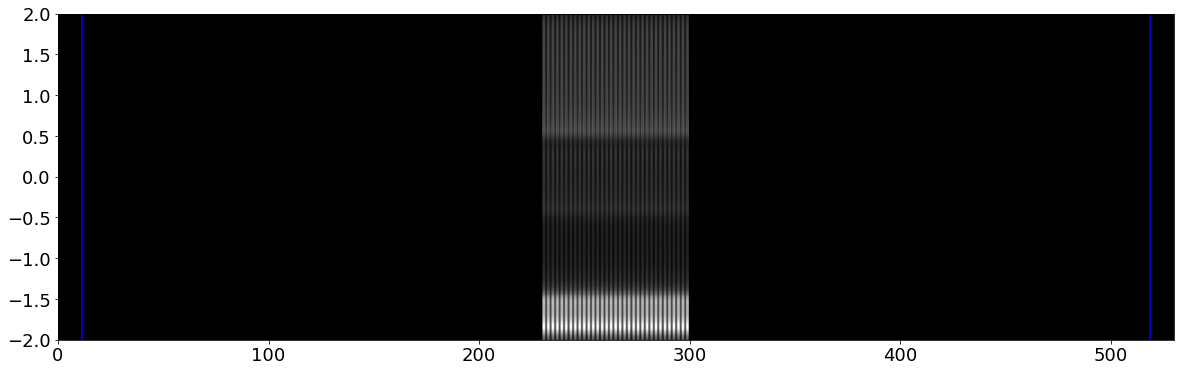

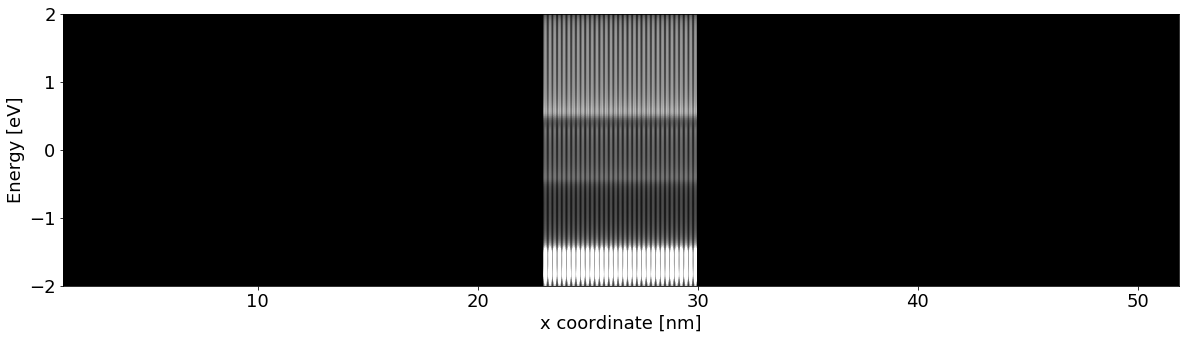

In [44]:
elim = (-2.0, 2.0)

geom_name = file_xyz.split("/")[-1].split(".")[0]

fig_folder = "./fig/h%.1f/" % height
fig_name = geom_name + "_c%d" % int(xcrop)
if surp:
    fig_name += "_sr"

e_i = (np.array((elim[0]-np.min(e_grid), elim[1]-np.max(e_grid)))/de).astype(int)
if e_i[0] < 0:
    e_i[0] = 0
if e_i[1] >= 0:
    e_i[1] = len(x_e_grid[0])

plt.figure(figsize=(20, 6))
plt.pcolormesh(x_e_grid[:, e_i[0]:e_i[1]],
               e_grid[:, e_i[0]:e_i[1]],
               pldos[:, e_i[0]:e_i[1]], cmap='gray')
# plot cropping and surpression lines
plt.axvline(x_e_grid[ncrop_l][0], color='b')
plt.axvline(x_e_grid[-ncrop_r][0], color='b')
if surp:
    for sr in xsurp:
        plt.axvline(sr[0], color='r')
        plt.axvline(sr[1], color='r')
        

plt.savefig(fig_folder+fig_name+"_ldos_whole.png", dpi=300, bbox_inches='tight')
plt.show()

matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(20, 5))

max_val = np.max(pldos_cropped[:, e_i[0]:e_i[1]])

plt.pcolormesh(x_e_grid_cropped[:, e_i[0]:e_i[1]]/10,
               e_grid_cropped[:, e_i[0]:e_i[1]],
               pldos_cropped[:, e_i[0]:e_i[1]], vmax=0.45*max_val, cmap='gray')
plt.ylabel('Energy [eV]')
plt.xlabel('x coordinate [nm]')
plt.savefig(fig_folder+fig_name+"_ldos.png", dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# in k-space

ft = np.fft.rfft(pldos_cropped, axis=0)
aft = np.abs(ft)


# Corresponding k points
k_arr = 2*np.pi*np.fft.rfftfreq(len(pldos_cropped[:, 0]), dx)
# Note: Since we took the FT of the charge density, the wave vectors are
#       twice the ones of the underlying wave function.
k_arr = k_arr / 2

n_k = len(aft[:, 0])

# Following has slight incorrect shift
#kmin = 0.0
#kmax = np.pi / dx
#kmax = kmax / 2
#k_arr = np.linspace(kmin, kmax, n_k)

k_grid, e_k_grid = np.meshgrid(k_arr, e_arr, indexing='ij')

# Lattice spacing for the ribbon = 3x c-c distance
# Brillouin zone boundary [1/angstroms]
bzboundary = np.pi / (3 * 1.42)

dk = k_arr[1]
bzb_i = int(np.round(bzboundary/dk))+1


In [46]:
def fold_bands(aft, k_arr, e_arr, bzboundary):
    
    dk = k_arr[1]
    bzb_i = int(np.round(bzboundary/dk))+1
    
    bz1_aft = np.zeros(np.shape(aft[:bzb_i]))
    bz1_kgrid, bz1_egrid = np.meshgrid(k_arr[:bzb_i], e_arr, indexing='ij')
    
    for ind, k_aft in enumerate(aft):
        k_val = k_arr[ind]
        bz_nr = int(k_val // bzboundary)
        frac_k = k_val % bzboundary
        if bz_nr % 2 == 0:
            k_folded = frac_k
        else:
            k_folded = bzboundary - frac_k
        
        bz1_ind = int(np.round(k_folded/dk))
        bz1_aft[bz1_ind, :] += k_aft
                       
        
    return bz1_aft, bz1_kgrid, bz1_egrid
        

bz1_aft, bz1_kgrid, bz1_egrid = fold_bands(aft, k_arr, e_arr, bzboundary)

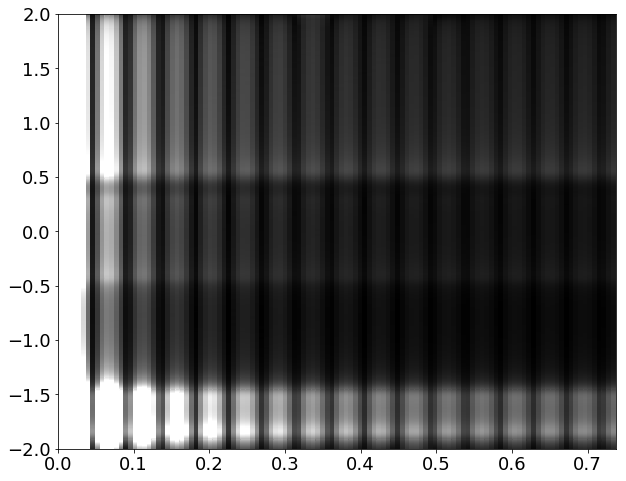

In [51]:
# NB: when plotting, the k and e grids corresponds to edges of the cells,
#     real data corresponds to middle points

plt.figure(figsize=(10, 8))

max_val = np.max(aft[:bzb_i, e_i[0]:e_i[1]])

plt.pcolormesh(bz1_kgrid[e_i[0]:e_i[1]],
               bz1_egrid[e_i[0]:e_i[1]],
               bz1_aft[e_i[0]:e_i[1]],
               vmax=0.1*max_val, cmap='gray')
plt.xlim([0.0, bzboundary])
plt.savefig(fig_folder+fig_name+"_ftsts.png", dpi=300, bbox_inches='tight')
plt.show()

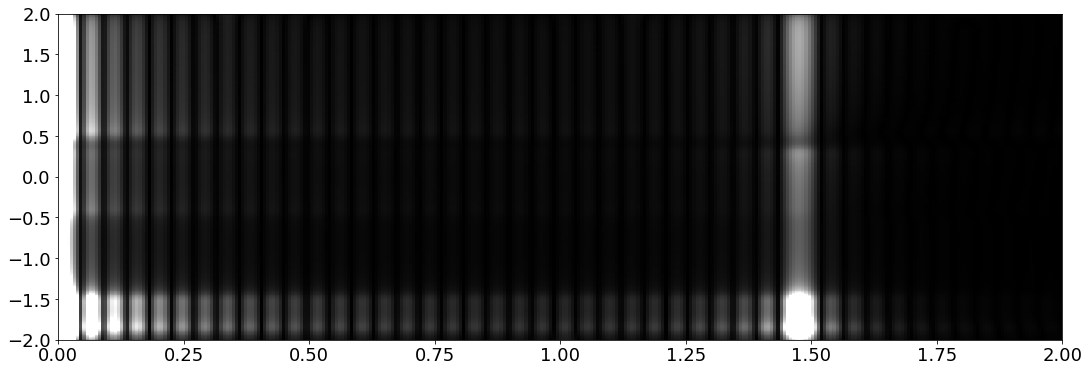

In [50]:
plt.figure(figsize=(18, 6))

max_val = np.max(aft[:, e_i[0]:e_i[1]])

plt.pcolormesh(k_grid[:, e_i[0]:e_i[1]],
               e_k_grid[:, e_i[0]:e_i[1]],
               aft[:, e_i[0]:e_i[1]],
               vmax=0.1*max_val, cmap='gray')
plt.xlim([0.0, 2.0])
plt.show()

# Together with QE bands

In [29]:
import xml.etree.ElementTree as et

In [30]:
def read_scf_fermi(scf_out_file):
    fermi = None
    with open(scf_out_file) as f:
        for l in f:
            if "Fermi energy" in l:
                fermi = float(l.split()[-2])
    if fermi is None:
        print("Couldn't find Fermi energy!")
    return fermi


def read_band_data(data_dir):
    
    data_file_xml = et.parse(data_dir+"data-file.xml")
    data_file_root = data_file_xml.getroot()

    kpts = []
    eig_vals = []

    # Loop through all K-POINTS xml nodes
    for kpt in data_file_root.find('EIGENVALUES'):
        #print(kpt.tag, kpt.attrib)

        # Save the kpoint coordinate to kpts[]
        kpt_coords = kpt.find('K-POINT_COORDS')
        kpts.append(np.double(kpt_coords.text.split()))
        #print("    ",kpts[-1])

        # Find the file containing eigenvalues corresponding to this k-point
        eig_datafile_xml = kpt.find('DATAFILE')
        eig_datafile = eig_datafile_xml.attrib['iotk_link']
        eig_datafile = eig_datafile[2:] # remove "./" from start
        #print("    ", eig_datafile)

        # Go retrieve the eigenvalues
        eig_file_xml = et.parse(data_dir+eig_datafile)
        eig_file_root = eig_file_xml.getroot()

        eigval_node = eig_file_root.find('EIGENVALUES')

        # Convert from hartree to eV and subtract E Fermi
        eig_vals.append(np.double(eigval_node.text.split())*27.21138602)
        #print(eig_vals[-1])

    return np.array(kpts), np.array(eig_vals)

In [31]:
# [[label, scf_output_file, bands_output_dir]]
datafiles = [["GTH unrelaxed",
              "/home/kristjan/sshfs/daint_scratch/qe_cnt/scf.out",
              "/home/kristjan/sshfs/daint_scratch/qe_cnt/bands/out/cnt.save/"]]
             #["ultrasoft relaxed",
             # "/home/kristjan/sshfs/daint_others_scratch/cpi/CNT/aiida.out",
             # "/home/kristjan/sshfs/daint_others_scratch/cpi/CNT/out/aiida.save/"]]

# {'label'} = [kpts, eig_vals]
datasets = {}

for df in datafiles:
    label = df[0]
    scf_f = df[1]
    band_f = df[2]
    efermi = read_scf_fermi(scf_f)
    kpts, eig_vals = read_band_data(band_f)
    eig_vals -= efermi
    datasets[label] = [kpts, eig_vals]

FileNotFoundError: [Errno 2] No such file or directory: '/home/kristjan/sshfs/daint_scratch/qe_cnt/scf.out'

In [32]:
plot_info = [("GTH unrelaxed", '-', 'b')]
             #("ultrasoft relaxed", '-', 'r')]

In [33]:

plt.figure(figsize=(10, 8))

max_val = np.max(aft[:bzb_i, e_i[0]:e_i[1]])

# xcrop c*maxval
# 10.0  0.01
# 50.0  0.001
# 100.0 0.001

plt.pcolormesh(k_grid[:bzb_i, e_i[0]:e_i[1]]*10,
               e_k_grid[:bzb_i, e_i[0]:e_i[1]],
               aft[:bzb_i, e_i[0]:e_i[1]],
               vmax=0.01*max_val, cmap='gray')

for pi in plot_info:
    label = pi[0]
    ls = pi[1]
    col = pi[2]
    
    kpts_raw, eig_vals = datasets[label]
    
    # Convert kpts to correct units (from QE: 0.5 corresponds to BZ edge)
    kpts = kpts_raw*bzboundary/0.5
    
    # 1/nm
    kpts *= 10
        
    for n in range(len(eig_vals[0])):
        if n == 0:
            plt.plot(np.abs(kpts[:, 0]), eig_vals[:, n], linestyle=ls, color=col, linewidth=0.5, label="QE bands")
        else:
            plt.plot(np.abs(kpts[:, 0]), eig_vals[:, n], linestyle=ls, color=col, linewidth=0.5)
            
    
plt.axhline(0.0, linestyle='--', color='k')
plt.xlim([0.0, bzboundary*10])
plt.ylim([-2, 2])
#plt.legend(loc='upper right')
plt.ylabel('$E-E_F$ [eV]')
plt.xlabel('k [nm$^{-1}$]')
#plt.savefig("./fig/"+name+".pdf", bbox_inches='tight')
plt.savefig(fig_folder+fig_name+"_ftsts.png", dpi=300, bbox_inches='tight')
plt.show()


KeyError: 'GTH unrelaxed'